In [25]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Connect to my database

conn = psycopg2.connect(
    host="",
    port="",  
    database="",  
    user="",  
    password=""  
)

cursor = conn.cursor()

In [26]:
import pandas as pd

# Query to get the data
query = """
SELECT date, location, opponent, 
       fg_1_19, fg_20_29, fg_30_39, fg_40_49, fg_50_plus, longest_fg, fg_percentage, fg_made, xp_made, points_scored, temp_f, precipitation_in, windspeed_mph, altitude_m, distance_from
FROM USC_Kicking_Stats;
"""

usc_kicking = pd.read_sql(query, conn)

# FG data provided as a list of strings
fg_data = [
    "2-3", "1-1", "1-2", "0-0", "3-3", "0-0", "1-3", "0-0", "1-1", "2-4", "1-1", "1-1", "1-2", "3-3", "2-2", "1-1", "2-2", "3-3",
    "1-2", "1-2", "2-2", "3-4", "2-2", "3-3", "0-2", "0-0", "2-3", "4-4", "1-2", "1-2", "1-2", "1-1", "1-1", "2-2", "0-0", "0-0",
    "2-2", "2-2", "0-1", "1-1", "1-1", "2-2", "1-2", "1-2", "5-5", "1-2", "0-0", "1-1", "1-1", "1-1", "0-1", "0-0", "1-1", "0-0",
    "2-3", "1-1", "0-0", "0-0", "2-3", "3-3", "0-0", "1-1", "0-0", "2-2", "0-1", "0-1", "2-2", "2-2", "1-2", "0-0", "0-0", "2-3",
    "0-1", "1-1", "2-2", "1-1", "0-0", "0-1", "2-3", "0-0", "1-2", "0-0", "1-1", "0-1", "2-2", "1-2", "1-1", "2-2", "2-4", "0-0",
    "0-1", "1-2", "1-1", "1-1", "3-3", "1-1", "3-5", "0-0", "1-1", "1-1", "0-0", "2-3", "1-2", "0-1", "2-2", "1-2", "2-2", "0-0",
    "2-2", "1-1", "0-0", "1-2", "2-2", "1-1", "0-1", "2-2", "0-0", "1-1", "1-1", "0-0", "0-0", "1-1", "0-0", "1-1", "3-3", "0-2",
    "0-0", "1-2", "0-0", "1-1", "1-3", "4-5", "1-1", "0-1", "2-2", "1-1", "0-0", "1-1"
]

# Ensure the length of fg_data matches the length of ucla_kicking DataFrame
if len(fg_data) == len(usc_kicking):
    # Add the FG data to the DataFrame
    usc_kicking['FG'] = fg_data

    # Split FG column into separate columns for makes and attempts
    usc_kicking[['fg_makes', 'fg_attempts']] = usc_kicking['FG'].str.split('-', expand=True)

    # Convert the makes and attempts columns to numeric, handling non-numeric cases
    usc_kicking['fg_makes'] = pd.to_numeric(usc_kicking['fg_makes'], errors='coerce')
    usc_kicking['fg_attempts'] = pd.to_numeric(usc_kicking['fg_attempts'], errors='coerce')

    # Calculate FG percentage
    usc_kicking['fg_percentage'] = (usc_kicking['fg_makes'] / usc_kicking['fg_attempts']) * 100

    # Handle any potential divisions by zero (e.g., if attempts are 0)
    usc_kicking['fg_percentage'] = usc_kicking['fg_percentage'].fillna(0)

    # Display the first few rows of the data
    print(usc_kicking.head())
else:
    print(f"Length of fg_data ({len(fg_data)}) does not match length of DataFrame ({len(usc_kicking)}).")


         date location          opponent  fg_1_19  fg_20_29  fg_30_39  \
0  2022-09-10        @          Stanford        0         0         0   
1  2022-09-17        H      Fresno State        0         0         0   
2  2022-09-24        @      Oregon State        0         0         0   
3  2022-10-01        H     Arizona State        0         0         0   
4  2022-10-08        H  Washington State        0         1         2   

   fg_40_49  fg_50_plus  longest_fg  fg_percentage  ...  xp_made  \
0         2           0          45      66.666667  ...        5   
1         1           0          41     100.000000  ...        6   
2         1           0          42      50.000000  ...        2   
3         0           0           0       0.000000  ...        6   
4         0           0          31     100.000000  ...        3   

   points_scored  temp_f  precipitation_in  windspeed_mph  altitude_m  \
0             11    81.8             0.035           15.4        30.0   
1     

/var/folders/d0/gj8tfnxn3jd2gjx88tk4mp180000gn/T/ipykernel_61773/1999115748.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  usc_kicking = pd.read_sql(query, conn)


In [21]:
# Lets see how many instances of each wind speed fall under arbitrary ranges


# Define the wind speed ranges
wind_speed_bins = [0, 5, 10, 15, 20, float('inf')]
wind_speed_labels = ['0-5 mph', '5-10 mph', '10-15 mph', '15-20 mph', '20+ mph']

# Create a new column in the dataframe for wind speed ranges
usc_kicking['Wind_Speed_Range'] = pd.cut(usc_kicking['windspeed_mph'], bins=wind_speed_bins, labels=wind_speed_labels, right=False)

# Count the number of observations in each wind speed range
wind_speed_distribution = usc_kicking['Wind_Speed_Range'].value_counts().sort_index()

# Display the distribution
print(wind_speed_distribution)


Wind_Speed_Range
0-5 mph       8
5-10 mph     75
10-15 mph    36
15-20 mph    10
20+ mph       9
Name: count, dtype: int64


In [27]:
usc_kicking['Wind_Range'] = pd.cut(
    usc_kicking['windspeed_mph'], 
    bins=[-np.inf, 5, 10, 15, 20, 100], 
    labels=['<5', '5-10', '10-15', '15-20', '20+']
)

In [28]:
# Check the number of rows in the ucla_kicking DataFrame
num_rows_dataframe = len(usc_kicking)

# Check the length of the fg_data list
num_entries_fg_data = len(fg_data)

# Compare the two lengths
if num_rows_dataframe == num_entries_fg_data:
    print("The number of FG data entries matches the number of rows in the DataFrame.")
else:
    print(f"Mismatch detected: DataFrame has {num_rows_dataframe} rows, but there are {num_entries_fg_data} FG data entries.")


The number of FG data entries matches the number of rows in the DataFrame.


/var/folders/d0/gj8tfnxn3jd2gjx88tk4mp180000gn/T/ipykernel_61773/2479336123.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_speed_fg_totals = usc_kicking.groupby('Wind_Speed_Range').agg({'fg_makes': 'sum', 'fg_attempts': 'sum'})


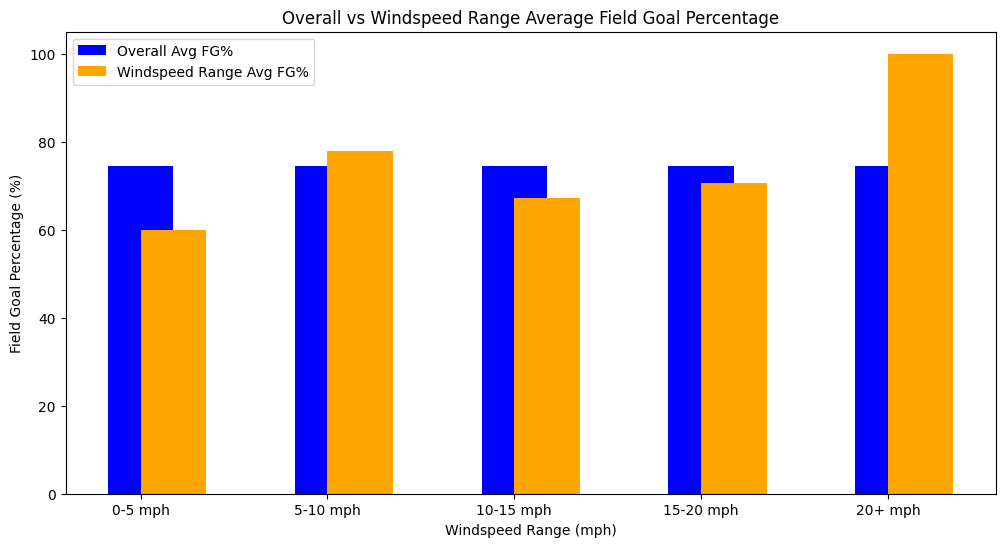

In [29]:
# Define the wind speed ranges
wind_speed_bins = [0, 5, 10, 15, 20, float('inf')]
wind_speed_labels = ['0-5 mph', '5-10 mph', '10-15 mph', '15-20 mph', '20+ mph']

# Create a new column in the dataframe for wind speed ranges
usc_kicking['Wind_Speed_Range'] = pd.cut(usc_kicking['windspeed_mph'], bins=wind_speed_bins, labels=wind_speed_labels, right=False)

# Calculate total FG makes and attempts for each wind speed range
wind_speed_fg_totals = usc_kicking.groupby('Wind_Speed_Range').agg({'fg_makes': 'sum', 'fg_attempts': 'sum'})

# Calculate FG percentage for each wind speed range
wind_speed_fg_totals['Wind_Range_Avg_FG%'] = (wind_speed_fg_totals['fg_makes'] / wind_speed_fg_totals['fg_attempts']) * 100

# Calculate the overall FG percentage across all wind speed ranges
overall_fg_makes = usc_kicking['fg_makes'].sum()
overall_fg_attempts = usc_kicking['fg_attempts'].sum()
overall_avg_fg = (overall_fg_makes / overall_fg_attempts) * 100

# Prepare data for plotting
avg_data = pd.DataFrame({
    'Wind_Range': wind_speed_fg_totals.index,
    'Overall_Avg_FG%': [overall_avg_fg] * len(wind_speed_fg_totals),
    'Wind_Range_Avg_FG%': wind_speed_fg_totals['Wind_Range_Avg_FG%'].values
})

# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(avg_data['Wind_Range'], avg_data['Overall_Avg_FG%'], width=bar_width, label='Overall Avg FG%', color='blue', align='center')
plt.bar(avg_data['Wind_Range'], avg_data['Wind_Range_Avg_FG%'], width=bar_width, label='Windspeed Range Avg FG%', color='orange', align='edge')

plt.xlabel('Windspeed Range (mph)')
plt.ylabel('Field Goal Percentage (%)')
plt.title('Overall vs Windspeed Range Average Field Goal Percentage')
plt.legend()

plt.show()
